# Step 2: Search
#### MORDM - Evaluating Multi-Disease Interventions - MSc Engineering and Policy Analysis

Shannon M. Gross

In [1]:
# standard packages
import numpy as np
import scipy as sp
import pandas as pd
import time, copy
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
pd.set_option('display.max_columns', 100)

# EMA imports
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress) 
from ema_workbench import (SequentialEvaluator, MultiprocessingEvaluator, Policy, Scenario, Constraint, CategoricalParameter,
                           TimeSeriesOutcome, ScalarOutcome, IntegerParameter, RealParameter, save_results, load_results, Model)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.parameters import create_parameters
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import (pairs_plotting, plotting, plotting_util, feature_scoring, parcoords) 
from ema_workbench.analysis.plotting import lines, Density
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

# problem-specific imports
from disease_model_problems import get_model_for_problem_formulation 

C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\connectors\__init__.py:27: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)
C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#### 2.1 Create reference scenario

In [2]:
disease_model = get_model_for_problem_formulation(1) 

reference_values = {"desire for improved sanitation":75, 'use HWT':75,
                    'Intensity of hygiene campaign':75, 'Reliability of vaccine supply':75, 
                    'seeking treatment':75, 'percent willing to accept MDA':75, 
                    'Cost of well repair':1350}

scen1 = {}

for key in disease_model.uncertainties:
    scen1.update({key.name: reference_values[key.name]})

reference_scenario = Scenario('reference', **scen1)

#### 2.2 Directed search w MOEA

In [7]:
nfe=15000
eps = [5, 5, 0.001, 10000000, 10000000] 

for PF in [2]:
    print("Retrieving Problem Formulation {}".format(PF))
    disease_model = get_model_for_problem_formulation(PF)
    
    convergence_metrics = [EpsilonProgress(),
                            HyperVolume.from_outcomes(disease_model.outcomes),
                           ]
    constraints = [Constraint("c1", outcome_names="CapEx", function=lambda x:max(0, x-1e+12)),
                   Constraint("c2", outcome_names="OpEx", function=lambda x:max(0, x-4.8e+12)),
                   Constraint("c3", outcome_names="Mortality", function=lambda x:max(0, x-26000)),
                   Constraint("c4", outcome_names="Morbidity", function=lambda x:max(0, x-190000)),
#                    Constraint("c5", outcome_names="Timeliness", function=lambda x:max(0, x-1.5e+12)),
                  ]

    start = time.time()
    with MultiprocessingEvaluator(disease_model, n_processes=8) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, 
                                                  searchover='levers', 
                                                  epsilons=eps,
                                                  reference=reference_scenario,
                                                  convergence=convergence_metrics,
                                                  constraints=constraints,
                                                  )
        
        file_name = './results/promising_candidates/search_PF{}_nfe{}_converg_test'.format(PF, nfe) + '.csv'
        c_name = './results/promising_candidates/convergence_PF{}_nfe{}_converg_test'.format(PF, nfe) + '.csv'
        results.to_csv(file_name)
        convergence.to_csv(c_name)
        
    end = time.time()
    print('Directed Search under PF {} took '.format(PF) + str(round((end - start)/60)) + ' mintues')
    print("")
    
#N.B. the results from optimize is a DataFrame with the decision variables and outcomes of interest

Retrieving Problem Formulation 2


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/15000 nfe
[MainProcess/INFO] generation 5: 499/15000 nfe
[MainProcess/INFO] generation 10: 993/15000 nfe
[MainProcess/INFO] generation 15: 1492/15000 nfe
[MainProcess/INFO] generation 20: 1991/15000 nfe
[MainProcess/INFO] generation 25: 2489/15000 nfe
[MainProcess/INFO] generation 30: 2985/15000 nfe
[MainProcess/INFO] generation 35: 3485/15000 nfe
[MainProcess/INFO] generation 40: 3985/15000 nfe
[MainProcess/INFO] generation 45: 4483/15000 nfe
[MainProcess/INFO] generation 50: 4982/15000 nfe
[MainProcess/INFO] generation 55: 5481/15000 nfe
[MainProcess/INFO] generation 60: 5980/15000 nfe
[MainProcess/INFO] generation 65: 6478/15000 nfe
[MainProcess/INFO] generation 70: 6973/15000 nfe
[MainProcess/INFO] generation 75: 7471/15000 nfe
[MainProcess/INFO] generation 80: 7971/15000 nfe
[MainProcess/INFO] generation 85: 8471/15000 nfe
[MainProcess/INFO] generation 90: 8970/15000 nfe
[MainProcess/INFO] generation 95: 9469/15000

Directed Search under PF 2 took 72 mintues



#### 2.3 Visualize search results

In [4]:
## Loop through to get limits
temp_df = pd.DataFrame() #Temporary empty dataframe

for PF in [2]:
    file_name = './results/promising_candidates/search_PF{}_nfe{}'.format(PF, nfe) + '.csv'
    results = pd.read_csv(file_name)
    disease_model = get_model_for_problem_formulation(PF)
    
    temp_df = temp_df.append(results, ignore_index=True) 
    
temp_df.rename(columns={'Availability HWT':'% HWT availability',
                        'Access to tmt':'% ORT availability',
                        'percent adults given MDA':'% Adults given MDA',
                        'percent youth given Albendazole':'% Youth given MDA',
                        'percentage of infants to vaccinate':'% Infants vaccinated',
                        'HW stations to build':'Handwashing stations to build',
                      }, 
                 inplace=True)
temp_df.drop(['Unnamed: 0.1','Unnamed: 0'], errors='ignore',inplace=True,axis=1)

colorder = ['Number of new latrines to build',
 'Number of latrines to maintain',
 'Number of new wells to drill',
 'Number of wells to repair',
 '% HWT availability',
 'Handwashing stations to build',
 '% Infants vaccinated',
 '% ORT availability',
 '% Adults given MDA',
 '% Youth given MDA',
 'Mortality',
 'Morbidity',
 'Timeliness',
 'CapEx',
 'OpEx']
temp_df = temp_df[colorder]


#NTS limits inside loop?

Found 1055 promising candidates under PF 1 


C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


Found 717 promising candidates under PF 2 


C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


Found 975 promising candidates under PF 3 


C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


Found 1026 promising candidates under PF 4 


C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


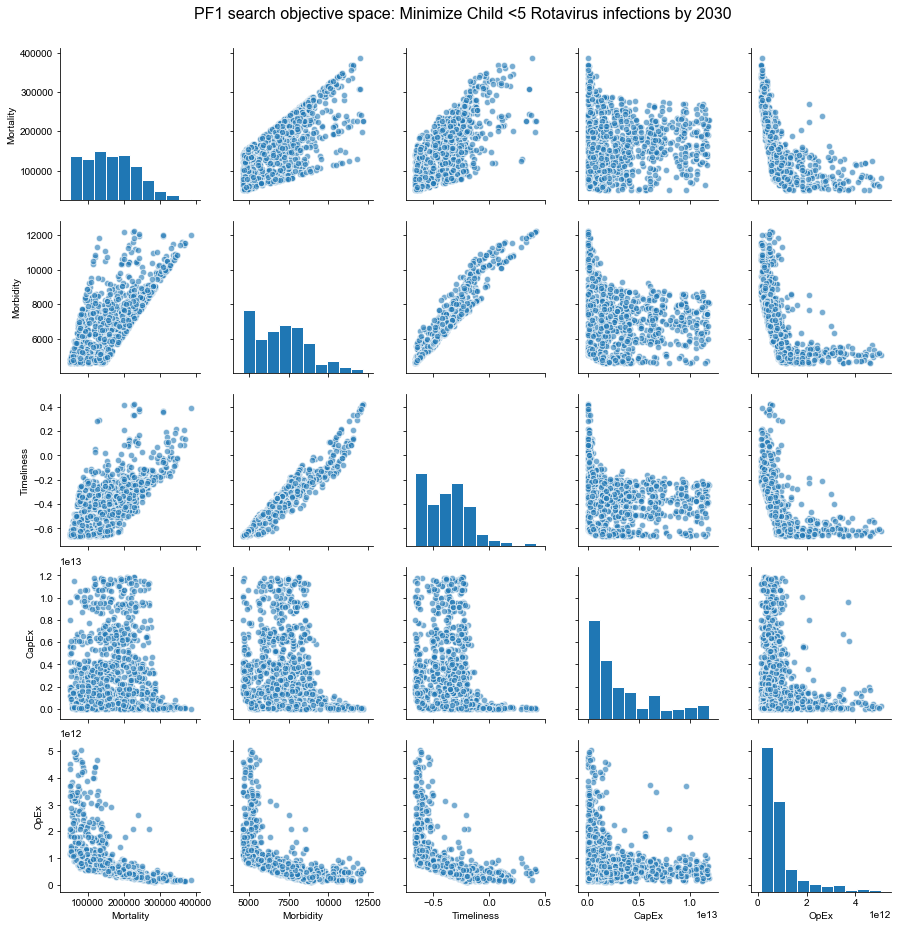

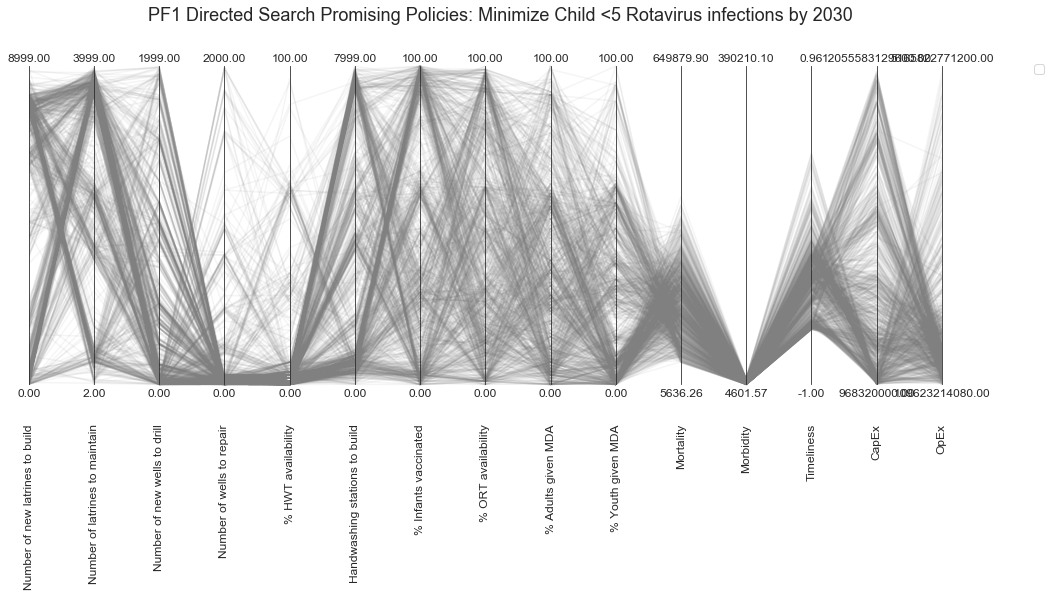

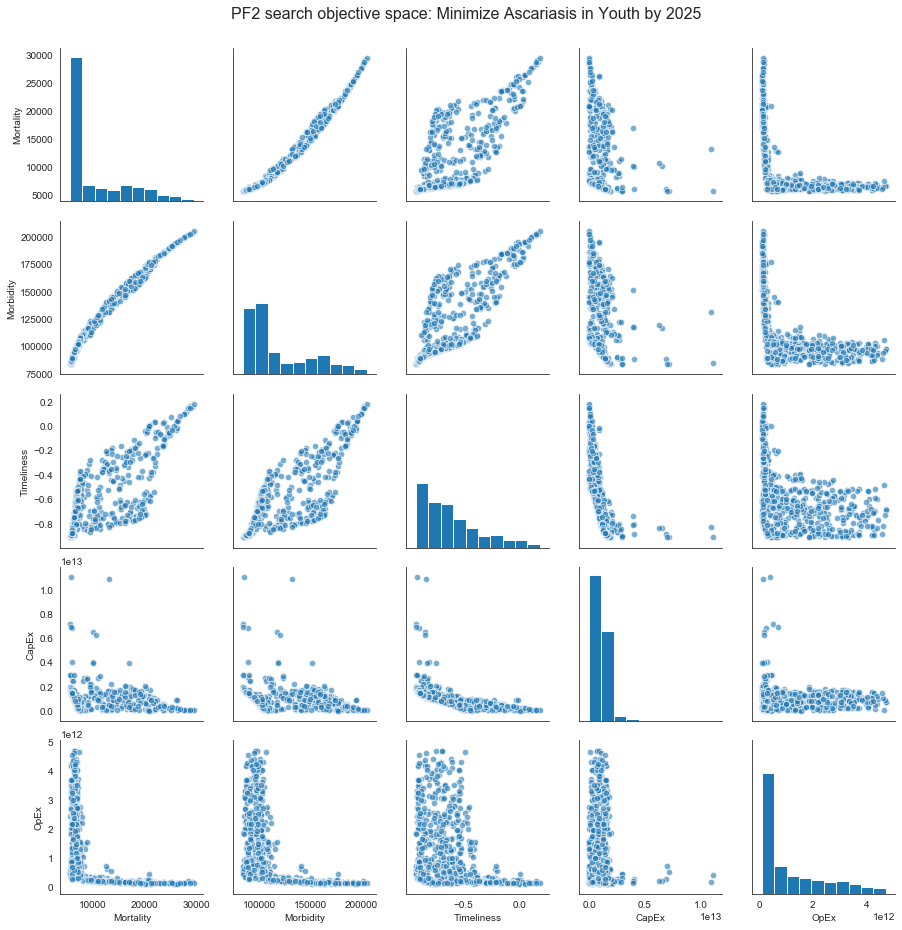

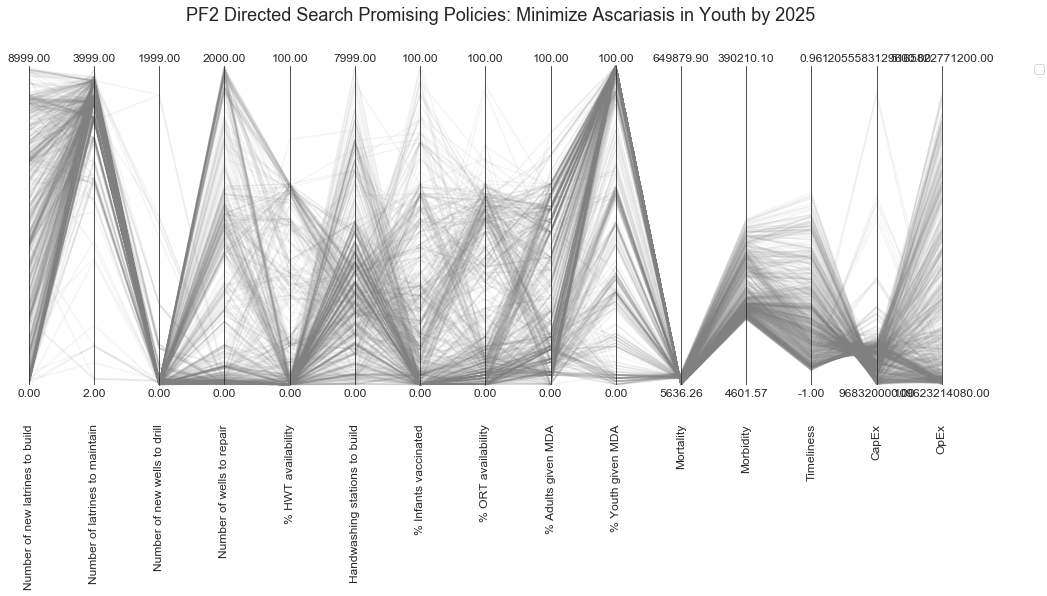

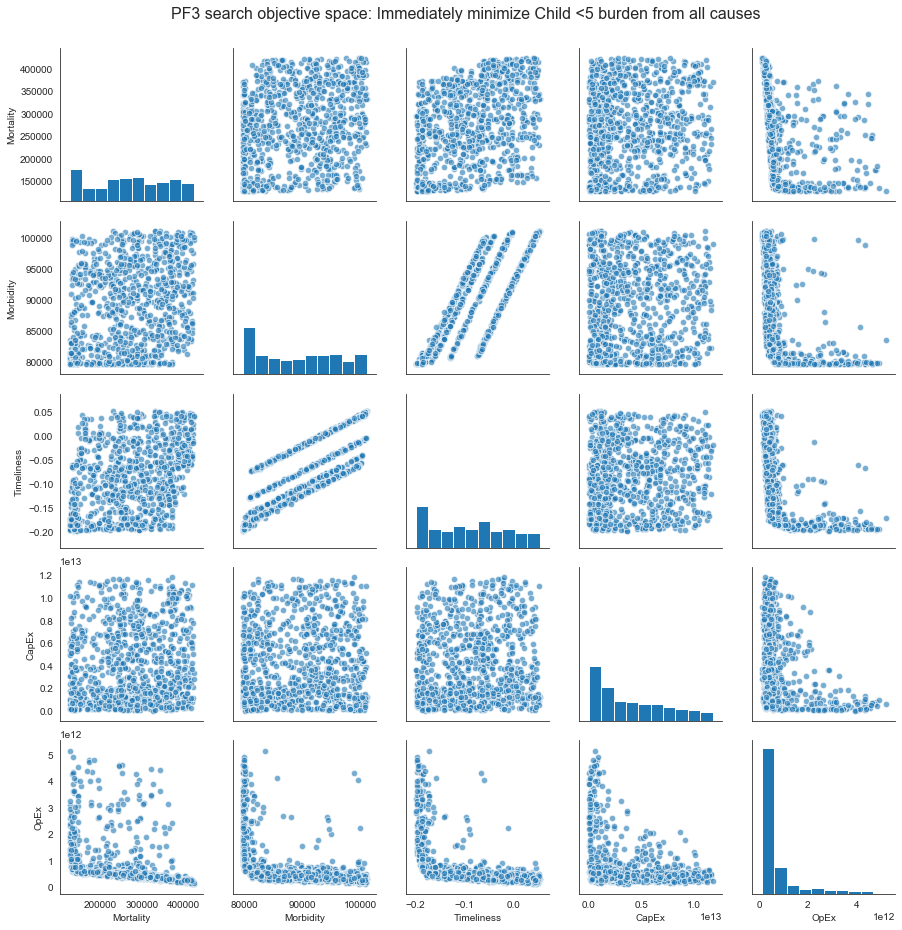

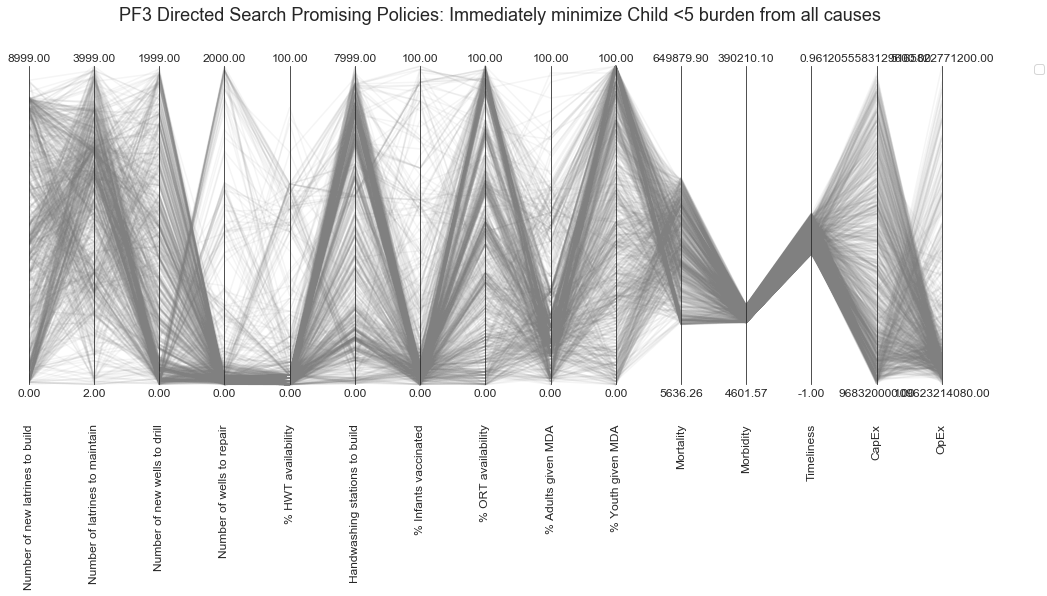

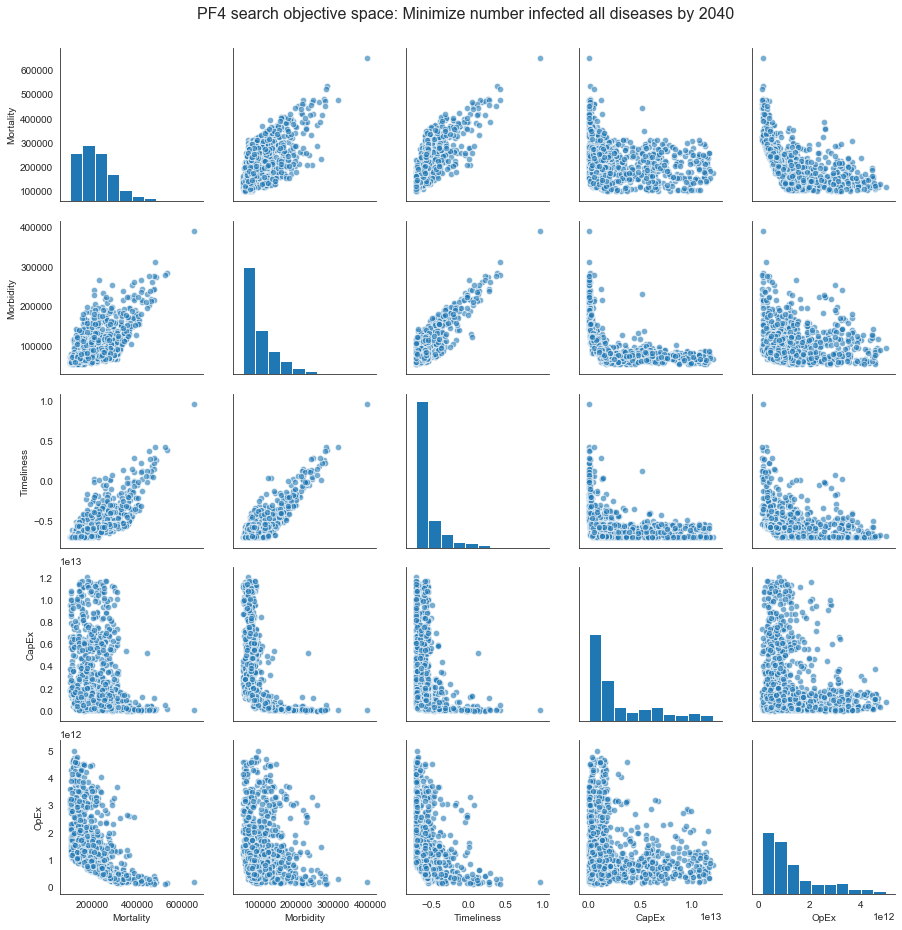

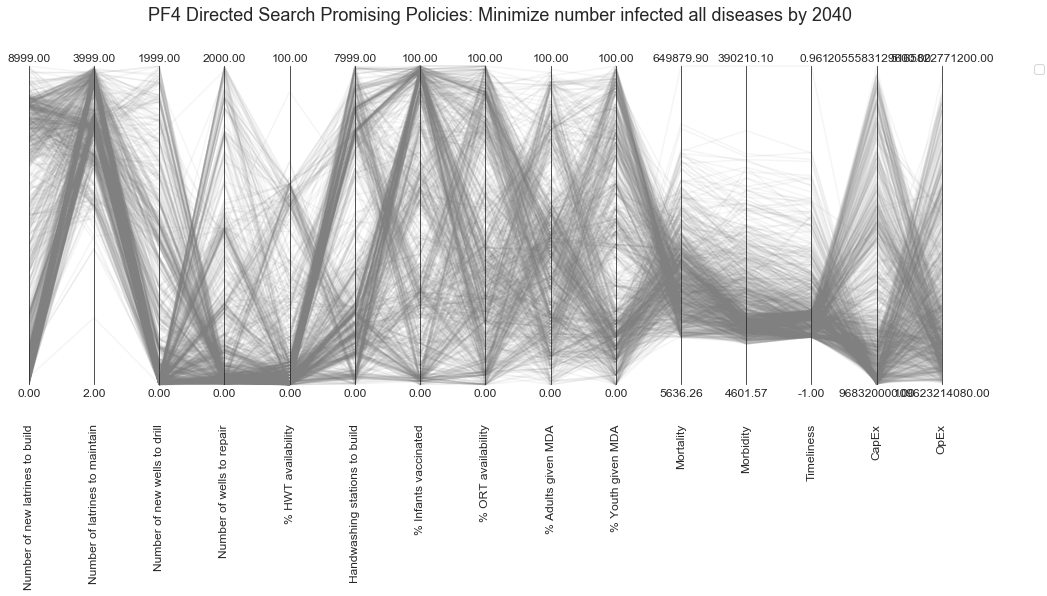

In [6]:
## VISUALIZE DIRECTED SEARCH RESULTS (Promising Candidates)
for PF in range(1,5):
    file_name = './results/promising_candidates/search_PF{}_nfe{}'.format(PF, nfe) + '.csv'
    results = pd.read_csv(file_name)
    disease_model = get_model_for_problem_formulation(PF)
    
    levers = [l.name for l in disease_model.levers]    
    df_levers = results[levers]
    out_list=[o.name for o in disease_model.outcomes]
    df_out=results[out_list]
    results.rename(columns={'Availability HWT':'% HWT availability',
                        'Access to tmt':'% ORT availability',
                        'percent adults given MDA':'% Adults given MDA',
                        'percent youth given Albendazole':'% Youth given MDA',
                        'percentage of infants to vaccinate':'% Infants vaccinated',
                        'HW stations to build':'Handwashing stations to build',
                      }, 
                 inplace=True)
    results.drop(['Unnamed: 0.1','Unnamed: 0'], errors='ignore', inplace=True,axis=1)
    results = results[colorder]
        
    # objective pairplot
    g = sns.PairGrid(df_out)
    g = g.map_diag(plt.hist, edgecolor="w")
    g = g.map_offdiag(plt.scatter, edgecolor="w",alpha=0.6, s=40) 
    plt.suptitle('PF{} search objective space: {}'.format(PF, disease_model.name), fontsize=16, y=1.03)
    print('Found ' + str(len(df_out)) + ' promising candidates under PF {} '.format(PF) )
    
    # parcoords plot
    limits = parcoords.get_limits(temp_df)
    limits.loc[0,['% HWT availability','% ORT availability','% Adults given MDA',
                  '% Youth given MDA','% Infants vaccinated','Handwashing stations to build']]=0
    limits.loc[1,['% HWT availability','% ORT availability','% Adults given MDA',
                  '% Youth given MDA','% Infants vaccinated']]=100
    limits.loc[0, 'Timeliness']=-1
    paraxes = parcoords.ParallelAxes(limits, fontsize=12,rot=90)
    paraxes.plot(results, color='grey', alpha= 0.08)

    figa = plt.gcf()
    figa.set_size_inches(14,8)
    paraxes.legend()
    plt.suptitle('PF{} Directed Search Promising Policies: {}'.format(PF, disease_model.name), fontsize=18, y=1.03) 
         
plt.show()

#### 2.4 Assess convergence

In [8]:
## VISUALIZE DIRECTED SEARCH RESULTS (Promising Candidates)
for PF in [2]:
    c_name = './results/promising_candidates/convergence_PF{}_nfe{}_converg_test'.format(PF, nfe) + '.csv'
    results = pd.read_csv(c_name)
convergence

epsilon_progress  hypervolume    nfe
0                  0     0.000000      0
1                  4     0.060738    100
2                207     0.162673   1193
3                526     0.187989   2291
4                792     0.204408   3385
5                996     0.208833   4483
6               1173     0.210946   5581
7               1345     0.212635   6675
8               1508     0.215509   7771
9               1663     0.217591   8771
10              1806     0.218368   9868
11              1821     0.218498  12257

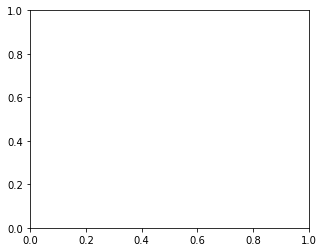

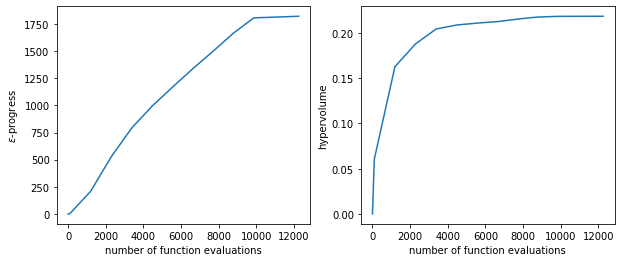

In [9]:
fig, ax1 = plt.subplots(ncols=1, sharex=True, figsize=(5,4))
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(10,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

#### 2.5 Seed analysis

In [ ]:
nfe=15000
eps = [5, 5, 0.001, 10000000, 10000000] 

for PF in [1,2,3,4]:
    print("Retrieving Problem Formulation {}".format(PF))
    disease_model = get_model_for_problem_formulation(PF)
    
    convergence_metrics = [EpsilonProgress(),
                           ]

    start = time.time()
    with MultiprocessingEvaluator(disease_model, n_processes=8) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, 
                                                  searchover='levers', 
                                                  epsilons=eps,
                                                  reference=reference_scenario,
                                                  convergence=convergence_metrics,
#                                                   constraints=constraints,
                                                  )
        
        file_name = './results/promising_candidates/search_PF{}_nfe{}'.format(PF, nfe) + '.csv'
        c_name = './results/promising_candidates/search_PF{}_nfe{}_convergence'.format(PF, nfe) + '.csv'
        results.to_csv(file_name)
        convergence.to_csv(c_name)
        
    end = time.time()
    print('Directed Search under PF {} took '.format(PF) + str(round((end - start)/60)) + ' mintues')
    print("")
    
#N.B. the results from optimize is a DataFrame with the decision variables and outcomes of interest

In [22]:
#SEED ANALYSIS
all_results = pd.DataFrame()

nfe=5000
eps = [5, 5, 0.001, 10000000, 10000000] 

for PF in [4]:
    print("Retrieving Problem Formulation {}".format(PF))
    disease_model = get_model_for_problem_formulation(PF)

    with MultiprocessingEvaluator(disease_model, n_processes=8) as evaluator:
        for rep in range(3):
            results = evaluator.optimize(nfe=nfe, 
                                     searchover='levers', 
                                     epsilons=eps,
                                     reference=reference_scenario,
                                     )
            results['seed_number']=rep  
            all_results = all_results.append(results, ignore_index=True)  
            
    seed_file_name = './results/promising_candidates/search_PF{}_nfe{}_seed_analysis'.format(PF, nfe) + '.csv'
    all_results.to_csv(seed_file_name)

Retrieving Problem Formulation 4


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/INFO] generation 10: 1000/5000 nfe
[MainProcess/INFO] generation 15: 1498/5000 nfe
[MainProcess/INFO] generation 20: 1997/5000 nfe
[MainProcess/INFO] generation 25: 2496/5000 nfe
[MainProcess/INFO] generation 30: 2992/5000 nfe
[MainProcess/INFO] generation 35: 3487/5000 nfe
[MainProcess/INFO] generation 40: 3983/5000 nfe
[MainProcess/INFO] generation 45: 4482/5000 nfe
[MainProcess/INFO] generation 50: 4982/5000 nfe
[MainProcess/INFO] optimization completed, found 504 solutions
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 497/5000 nfe
[MainProcess/INFO] generation 10: 996/5000 nfe
[MainProcess/INFO] generation 15: 1496/5000 nfe
[MainProcess/INFO] generation 20: 1995/5000 nfe
[MainProcess/INFO] generation 25: 2494/5000 nfe
[MainProcess/INFO] generation 30: 2993/5000 nfe
[MainProcess/INFO] generation 35: 3491/5000 nfe
[MainP

C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\shannonsgross\Anaconda3\envs\thesis\lib\site-packages\ema_workbench\analysis\parcoords.py:225: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


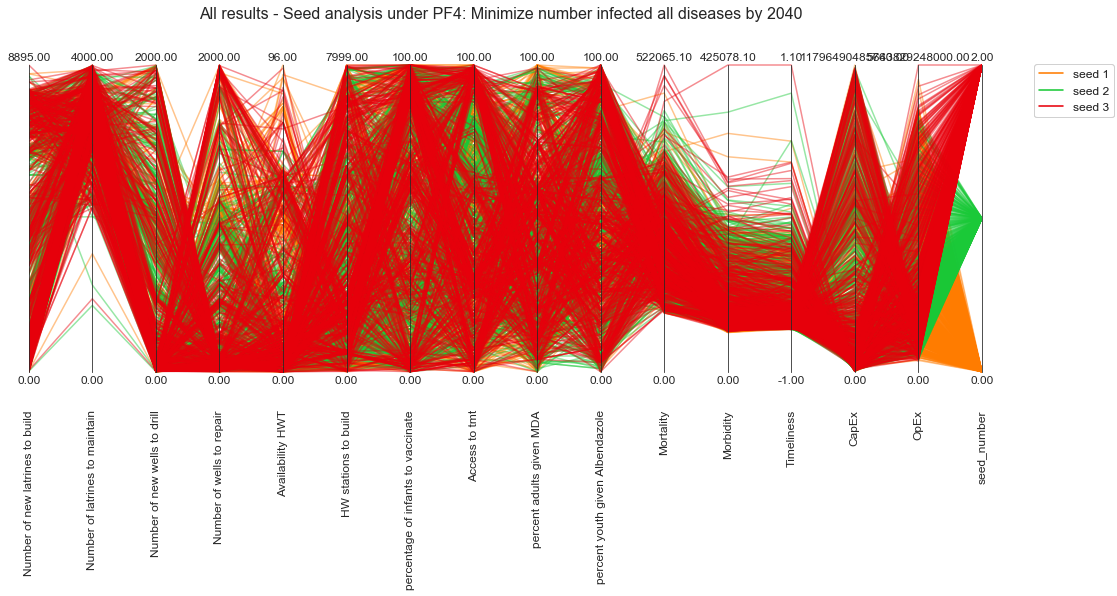

In [23]:
# Make plot of the different seeds

# parcoords plot
limits = parcoords.get_limits(all_results)
limits.loc[0, :]=0
limits.loc[0, 'Timeliness']=-1
paraxes = parcoords.ParallelAxes(limits, fontsize=12,rot=90)

for i,p in enumerate(set(all_results['seed_number'])):
    paraxes.plot(all_results[all_results['seed_number']==i], 
                 label='seed {}'.format(p+1), 
                 color=sns.color_palette("bright")[i+1],
                 alpha= 0.45)

paraxes.legend()

figa = plt.gcf()
figa.set_size_inches(14,8)
paraxes.legend()
plt.suptitle('All results - Seed analysis under PF{}: {}'.format(PF, disease_model.name), fontsize=16, y=1.03)

plt.show()